In [1]:
%load_ext autoreload
%autoreload

In [2]:
import matplotlib.pyplot as plt

In [3]:
import argparse
import torch
import torch.nn.functional as F
from torch.optim import Adam
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader
import os,random
import os.path as osp
import sys
import time
from utils import *

from mace.mace_gnn import MBPGNN

/n/fs/vl/rb4785/miniforge3/envs/mace_ng/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [4]:
from NeuroGraph.datasets import NeuroGraphDataset

In [177]:
root = "/n/fs/scratch/rb4785/NeuroGraph_data/"
dataset = NeuroGraphDataset(root=root, name="HCPAge")

Processing...
Done!


In [66]:
d = dataset[0]

In [68]:
d.vectors

tensor([0.])

In [31]:
torch.zeros((1))

tensor([0.])

In [69]:
l = torch.nn.Linear(8, 16)

In [94]:
d.x.to('cpu')

tensor([[ 0.0000,  0.5451,  0.5538,  ...,  0.1681,  0.0870,  0.1291],
        [ 0.5451,  0.0000,  0.6339,  ...,  0.0127, -0.0067,  0.0350],
        [ 0.5538,  0.6339,  0.0000,  ...,  0.1448,  0.1179,  0.1731],
        ...,
        [ 0.1681,  0.0127,  0.1448,  ...,  0.0000,  0.3854,  0.3324],
        [ 0.0870, -0.0067,  0.1179,  ...,  0.3854,  0.0000,  0.6345],
        [ 0.1291,  0.0350,  0.1731,  ...,  0.3324,  0.6345,  0.0000]])

In [87]:
l(x).tanh()

tensor([[ 0.6720,  0.7679,  0.6730,  0.5543,  0.2376,  0.3331,  0.1627, -0.6665,
         -0.3972,  0.2057,  0.9348, -0.6944,  0.1965, -0.3750,  0.1426,  0.7873]],
       grad_fn=<TanhBackward0>)

In [95]:
from e3nn import o3

In [141]:
ir = o3.Irreps("1x0e")
ir.num_irreps

1

In [178]:
[d.x.shape for d in dataset]

[torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 torch.Size([1000, 1000]),
 

In [135]:
i = o3.Irreps([(16, (0,1))])
o3.Irrep(0, 1).count(1)

NotImplementedError: 

In [159]:
y = torch.randn((7,3))

In [179]:
[x for x in [tuple(d.x.shape) for d in dataset] if x != (1000, 1000)]

[]

In [199]:
ir = o3.Irreps("256x0e + 256x1o")
ir

256x0e+256x1o

In [204]:
dataset[0].num_nodes

1000

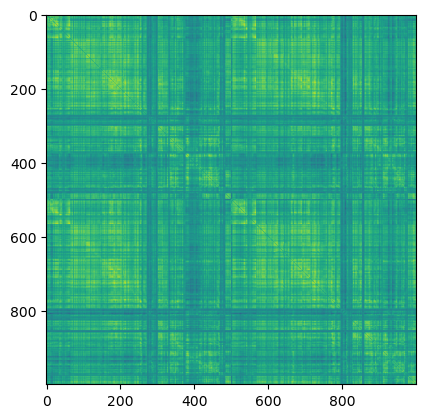

In [194]:
plt.imshow(dataset[0].x)

In [172]:
d = dataset[-1]


In [173]:
d

Data(x=[1000, 1000], edge_index=[2, 45780], y=[1], edge_attr=[1], vectors=[1])

In [114]:
irreps = "2x0e"
if irreps.strip() != "":
  for mul_ir in irreps.split('+'):
      if 'x' in mul_ir:
          mul, ir = mul_ir.split('x')
          print(mul, ir)
          print("mul = int(mul)")
          print("ir = Irrep(ir)")
      else:
          mul = 1
          print("ir = Irrep(mul_ir)")

      # assert isinstance(mul, int) and mul >= 0
      # out.append(_MulIr(mul, ir))

2 0e
mul = int(mul)
ir = Irrep(ir)


# Spherical Harmonics

In [27]:
import e3nn
from e3nn import o3

In [67]:
sh_irreps = o3.Irreps.spherical_harmonics(0) # spherical harmonics irreps
# up to l=3
print(sh_irreps, sh_irreps.dim)

1x0e 1


In [68]:
sh = o3.SphericalHarmonics(
  sh_irreps, normalize=True, normalization='component'
)

In [71]:
sh(torch.Tensor([[2,0,0], [0,0,1]]))

tensor([[1.],
        [1.]])

# PANDAS

In [5]:
import pandas as pd

In [7]:
df = pd.read_csv("results/results_new.csv")
df

,label,dataset,model,epochs,best_val_acc,best_val_loss,test_acc,test_loss
0,novecs,HCPAge,MBPGNN,10,0.514019,0.0,0.403756,0.278502
1,novecs,HCPAge,GCNConv,10,0.467290,0.0,0.441315,0.278897
2,novecs,HCPAge,GraphConv,10,0.411215,0.0,0.460094,0.275382
3,novecs,HCPTask,MBPGNN,10,0.728859,0.0,0.713230,0.456199
4,novecs,HCPTask,GCNConv,10,0.602685,0.0,0.581598,0.445058
5,novecs,HCPTask,GraphConv,10,0.600000,0.0,0.613835,0.438387
6,novecs,HCPAge,MBPGNN,100,0.514019,0.0,0.422535,0.265355
7,novecs,HCPAge,GCNConv,100,0.514019,0.0,0.450704,0.259396
8,novecs,HCPAge,GraphConv,100,0.495327,0.0,0.455399,0.280556
9,novecs,HCPTask,MBPGNN,100,0.965101,0.0,0.958361,0.304897


In [13]:
df[df.epochs == 100].groupby(['dataset', 'model', 'label']).aggregate('mean', 'label')# .sort_values('test_acc', ascending=False3)

epochs  best_val_acc  best_val_loss  test_acc  \
dataset model       label                                                       
HCPAge  GCNConv     novecs       100.0      0.514019            0.0  0.450704   
                    randn_vecs   100.0      0.514019            0.0  0.441315   
        GeneralConv novecs       100.0      0.457944            0.0  0.431925   
                    randn_vecs   100.0      0.476636            0.0  0.408451   
        GraphConv   novecs       100.0      0.495327            0.0  0.455399   
                    randn_vecs   100.0      0.514019            0.0  0.403756   
        MBPGNN      novecs       100.0      0.514019            0.0  0.422535   
                    randn_vecs   100.0      0.514019            0.0  0.446009   
HCPTask GCNConv     novecs       100.0      0.936913            0.0  0.925453   
                    randn_vecs   100.0      0.940940            0.0  0.926797   
        GeneralConv novecs       100.0      0.951678            0.0  0.942915   
                    randn_vecs   100.0      0.954362            0.0  0.954332   
        GraphConv   novecs       100.0      0.932886            0.0  0.917394   
                    randn_vecs   100.0      0.927517            0.0  0.914036   
        MBPGNN      novecs       100.0      0.965101            0.0  0.958361   
                    randn_vecs   100.0      0.966443            0.0  0.968435   

                                test_loss  
dataset model       label                  
HCPAge  GCNConv     novecs       0.259396  
                    randn_vecs   0.261975  
        GeneralConv novecs       0.273598  
                    randn_vecs   0.259874  
        GraphConv   novecs       0.280556  
                    randn_vecs   0.280955  
        MBPGNN      novecs       0.265355  
                    randn_vecs   0.283035  
HCPTask GCNConv     novecs       0.316722  
                    randn_vecs   0.313339  
        GeneralConv novecs       0.313552  
                    randn_vecs   0.308705  
        GraphConv   novecs       0.307715  
                    randn_vecs   0.317106  
        MBPGNN      novecs       0.304897  
                    randn_vecs   0.313503

In [14]:
his = pd.read_csv("results/history.csv")

,label,dataset,model,epoch,loss,val_acc,test_acc
0,randn_vecs,HCPAge,MBPGNN,0,0.289204,0.439252,0.347418
1,randn_vecs,HCPAge,MBPGNN,1,0.284958,0.411215,0.370892
2,randn_vecs,HCPAge,MBPGNN,2,0.287378,0.392523,0.403756
3,randn_vecs,HCPAge,MBPGNN,3,0.275120,0.429907,0.361502
4,randn_vecs,HCPAge,MBPGNN,4,0.280605,0.411215,0.417840
...,...,...,...,...,...,...,...
795,randn_vecs,HCPTask,GeneralConv,95,0.290123,0.934228,0.936199
796,randn_vecs,HCPTask,GeneralConv,96,0.291817,0.954362,0.954332
797,randn_vecs,HCPTask,GeneralConv,97,0.286019,0.953020,0.960376
798,randn_vecs,HCPTask,GeneralConv,98,0.282919,0.912752,0.912021


/tmp/ipykernel_586854/1209188985.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_586854/1209188985.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


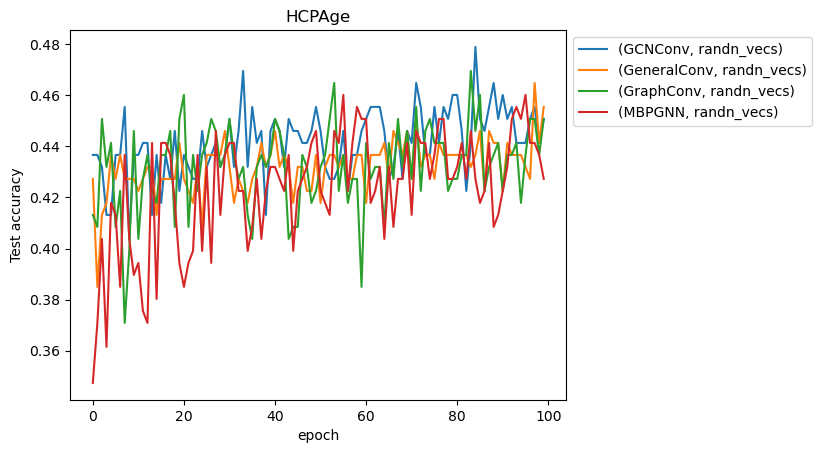

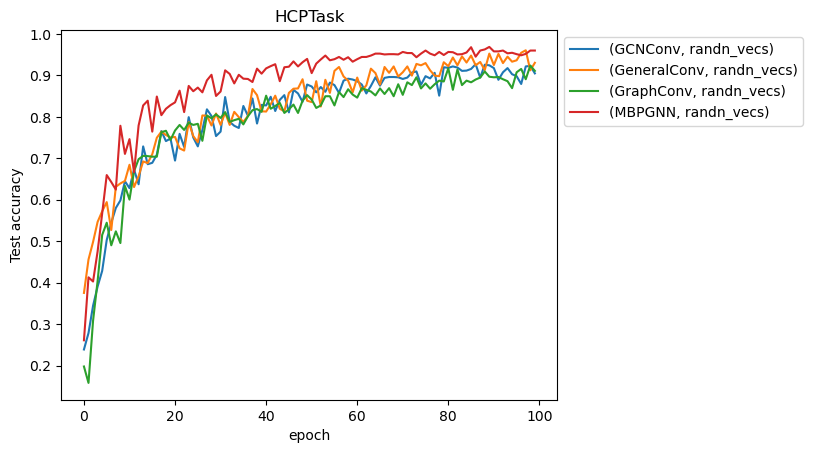

In [45]:
# Plot test_acc
for (dataset), g in his.groupby('dataset'):
    fig, ax = plt.subplots()
    for title, group in g[g.dataset == dataset].groupby(['model', 'label']):
        group.plot('epoch', 'test_acc', label=title, ax=ax)
    
    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_title(dataset)
    ax.set_ylabel("Test accuracy")
    fig.show()